In [1]:
import os

# read text file into string
current_dir = os.getcwd()
file_path = f"{current_dir}/checkpoints/livecells/cct_livecells_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/log.txt"
# file_path = f"{current_dir}/checkpoints/bccd/fixmatch_bccd_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/log.txt"
with open(file_path, "r") as f:
    logs = f.read()

logs

'Epoch 0, iter 1, Dice Sup Loss: 0.43137, Dice Unsup Loss: 0.06047, BCE Sup Loss: 0.7127, BCE UnSup Loss: 0.72528\nEpoch 0, iter 2, Dice Sup Loss: 0.42233, Dice Unsup Loss: 0.05436, BCE Sup Loss: 0.67623, BCE UnSup Loss: 0.70943\nEpoch 0, iter 3, Dice Sup Loss: 0.43583, Dice Unsup Loss: 0.05804, BCE Sup Loss: 0.66168, BCE UnSup Loss: 0.70416\nEpoch 0, iter 4, Dice Sup Loss: 0.35209, Dice Unsup Loss: 0.05219, BCE Sup Loss: 0.72988, BCE UnSup Loss: 0.6949\nEpoch 0, iter 5, Dice Sup Loss: 0.46153, Dice Unsup Loss: 0.05112, BCE Sup Loss: 0.66479, BCE UnSup Loss: 0.69408\nEpoch 0, iter 6, Dice Sup Loss: 0.35922, Dice Unsup Loss: 0.04147, BCE Sup Loss: 0.69044, BCE UnSup Loss: 0.68814\nEpoch 0, iter 7, Dice Sup Loss: 0.4556, Dice Unsup Loss: 0.03735, BCE Sup Loss: 0.6752, BCE UnSup Loss: 0.6889\nEpoch 0, iter 8, Dice Sup Loss: 0.40036, Dice Unsup Loss: 0.02957, BCE Sup Loss: 0.67307, BCE UnSup Loss: 0.6863\nEpoch 0, iter 9, Dice Sup Loss: 0.43033, Dice Unsup Loss: 0.02903, BCE Sup Loss: 0.66

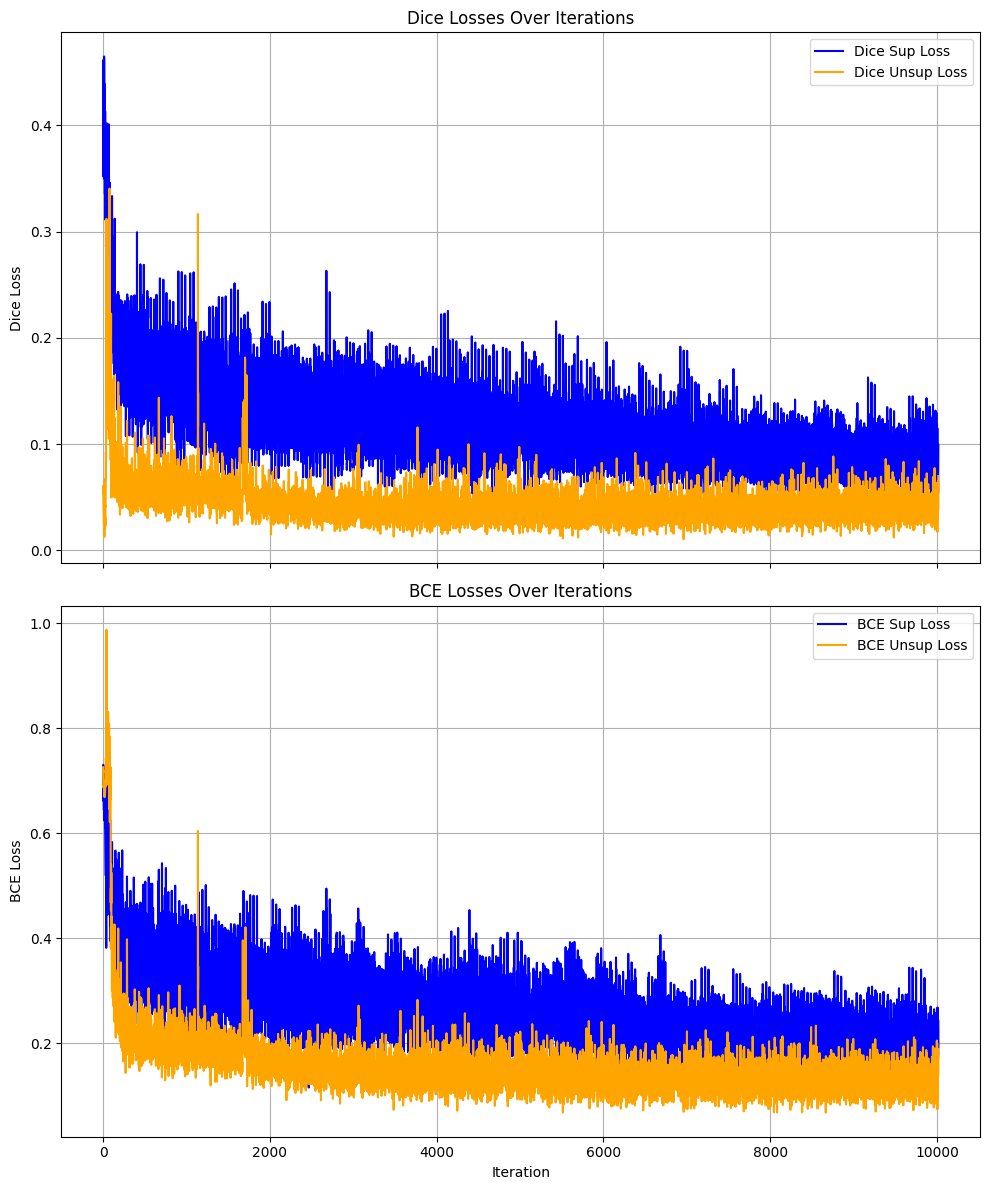

In [2]:
import re
import matplotlib.pyplot as plt

# Compile regular expression to parse the relevant lines
pattern = re.compile(
    r"Epoch (\d+), iter (\d+), Dice Sup Loss: ([\d.]+), Dice Unsup Loss: ([\d.]+), BCE Sup Loss: ([\d.]+), BCE UnSup Loss: ([\d.]+)"
)

# Initialize lists to store the extracted values
iters = []
dice_sup_losses = []
dice_unsup_losses = []
bce_sup_losses = []
bce_unsup_losses = []

# Parse the logs
for epoch, line in enumerate(logs.strip().split("\n")):
    match = pattern.match(line)
    if match:
        dice_sup_loss = float(match.group(3))
        dice_unsup_loss = float(match.group(4))
        bce_sup_loss = float(match.group(5))
        bce_unsup_loss = float(match.group(6))

        # Append values to the lists
        iters.append(epoch)
        dice_sup_losses.append(dice_sup_loss)
        dice_unsup_losses.append(dice_unsup_loss)
        bce_sup_losses.append(bce_sup_loss)
        bce_unsup_losses.append(bce_unsup_loss)


# Function to plot the data in subplots
def plot_losses_subplots(iters, dice_losses, bce_losses):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

    # Plot Dice losses
    ax1.plot(iters, dice_losses["Dice Sup Loss"], label="Dice Sup Loss", color="blue")
    ax1.plot(
        iters, dice_losses["Dice Unsup Loss"], label="Dice Unsup Loss", color="orange"
    )
    ax1.set_ylabel("Dice Loss")
    ax1.set_title("Dice Losses Over Iterations")
    ax1.legend()
    ax1.grid(True)

    # Plot BCE losses
    ax2.plot(iters, bce_losses["BCE Sup Loss"], label="BCE Sup Loss", color="blue")
    ax2.plot(
        iters, bce_losses["BCE Unsup Loss"], label="BCE Unsup Loss", color="orange"
    )
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("BCE Loss")
    ax2.set_title("BCE Losses Over Iterations")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# Prepare loss values for plotting
dice_losses = {
    "Dice Sup Loss": dice_sup_losses,
    "Dice Unsup Loss": dice_unsup_losses,
}

bce_losses = {
    "BCE Sup Loss": bce_sup_losses,
    "BCE Unsup Loss": bce_unsup_losses,
}

# Plot the data
plot_losses_subplots(iters, dice_losses, bce_losses)

# Plot inferences

In [3]:
import yaml
from Datasets.create_dataset import get_dataset, SkinDataset2, StrongWeakAugment2
from Utils.pieces import DotDict

config = yaml.load(open("Configs/multi_train_local.yml"), Loader=yaml.FullLoader)
config["fold"] = 1
config["data"]["supervised_ratio"] = 0.25
# update dataset
ls_update_keys = [
    "name",
    "save_folder",
    "test_folder",
    "train_folder",
    "val_folder",
]
for key in ls_update_keys:
    config["data"][key] = config["data"][key].replace("isic2018", "lisc")

config = DotDict(config)
dataset = get_dataset(
    config,
    img_size=config["data"]["img_size"],
    supervised_ratio=config["data"]["supervised_ratio"],
    train_aug=config["data"]["train_aug"],
    k=config["fold"],
    lb_dataset=SkinDataset2,
    ulb_dataset=StrongWeakAugment2,
)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


Train Data: A172_Phase_A7_1_00d00h00m_3.npy - 1296
Labeled Data: A172_Phase_A7_1_00d20h00m_1.npy - 324
Unlabeled Data: A172_Phase_A7_1_00d00h00m_3.npy - 972
Val Data: A172_Phase_A7_1_00d12h00m_1.npy - 324


In [5]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from Models.Transformer.SwinUnet import SwinUnet
from Utils.losses import dice_loss


# Assuming your model is a custom ConvNet
def load_model(model_path):
    model = model = SwinUnet(img_size=224)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model


# Assuming a loss function (e.g., BCEWithLogitsLoss)
def calculate_loss(output, target):
    criterion = nn.BCEWithLogitsLoss()  # or another loss function
    loss = criterion(output, target)
    return loss.item()


# Function to plot top bad inferences
def plot_top_bad_inferences(bad_inferences, num_images=10, cols=5):
    rows = num_images // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

    for i, (image, seg, loss) in enumerate(bad_inferences[:num_images]):
        ax = axes[i // cols, i % cols]

        # plot the original image
        image = image.reshape(3, 224, 224).permute(1, 2, 0).cpu().numpy()

        # Apply threshold to get binary mask
        seg = torch.sigmoid(seg).squeeze().detach().cpu().numpy()
        binary_mask = (seg > 0.5).astype(np.uint8)

        # Find contours in the binary mask
        contours, _ = cv2.findContours(
            binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # Draw contours in red
        contour_image = cv2.drawContours(image.copy(), contours, -1, (255, 0, 0), 5)

        ax.imshow(contour_image)
        ax.axis("off")
        ax.set_title(f"Loss: {loss:.4f}")

    plt.tight_layout()
    plt.show()


model_path = "checkpoints/livecells/cct_livecells_supervised_ratio_0.25_conf_thresh_0.8_fold_1_seed_1_0.25/fold1/best.pth"
model = load_model(model_path)

test_loader = torch.utils.data.DataLoader(
    dataset["val_dataset"],
    batch_size=1,
    shuffle=False,
    num_workers=config.test.num_workers,
    pin_memory=True,
    drop_last=False,
)
criterion = [nn.BCELoss(), dice_loss]

bad_inferences = []
for batch_id, batch in enumerate(test_loader):
    img = batch["image"].cpu().float()
    label = batch["label"].cpu().float()

    batch_len = img.shape[0]

    with torch.no_grad():

        output = model(img)

        output = torch.sigmoid(output)

        # calculate loss
        assert output.shape == label.shape
        losses = []
        for function in criterion:
            losses.append(function(output, label))

        bad_inferences.append((img, output, losses[0]))

# Sort by loss in descending order
bad_inferences.sort(key=lambda x: x[2], reverse=True)

# Plot top 10 bad inferences
plot_top_bad_inferences(bad_inferences)

SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


/tmp/ipykernel_682138/4183991924.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


RuntimeError: Error(s) in loading state_dict for SwinUnet:
	Missing key(s) in state_dict: "swin_unet.layers_up.0.expand.weight", "swin_unet.layers_up.0.norm.weight", "swin_unet.layers_up.0.norm.bias", "swin_unet.layers_up.1.blocks.0.norm1.weight", "swin_unet.layers_up.1.blocks.0.norm1.bias", "swin_unet.layers_up.1.blocks.0.attn.relative_position_bias_table", "swin_unet.layers_up.1.blocks.0.attn.relative_position_index", "swin_unet.layers_up.1.blocks.0.attn.qkv.weight", "swin_unet.layers_up.1.blocks.0.attn.qkv.bias", "swin_unet.layers_up.1.blocks.0.attn.proj.weight", "swin_unet.layers_up.1.blocks.0.attn.proj.bias", "swin_unet.layers_up.1.blocks.0.norm2.weight", "swin_unet.layers_up.1.blocks.0.norm2.bias", "swin_unet.layers_up.1.blocks.0.mlp.fc1.weight", "swin_unet.layers_up.1.blocks.0.mlp.fc1.bias", "swin_unet.layers_up.1.blocks.0.mlp.fc2.weight", "swin_unet.layers_up.1.blocks.0.mlp.fc2.bias", "swin_unet.layers_up.1.blocks.1.attn_mask", "swin_unet.layers_up.1.blocks.1.norm1.weight", "swin_unet.layers_up.1.blocks.1.norm1.bias", "swin_unet.layers_up.1.blocks.1.attn.relative_position_bias_table", "swin_unet.layers_up.1.blocks.1.attn.relative_position_index", "swin_unet.layers_up.1.blocks.1.attn.qkv.weight", "swin_unet.layers_up.1.blocks.1.attn.qkv.bias", "swin_unet.layers_up.1.blocks.1.attn.proj.weight", "swin_unet.layers_up.1.blocks.1.attn.proj.bias", "swin_unet.layers_up.1.blocks.1.norm2.weight", "swin_unet.layers_up.1.blocks.1.norm2.bias", "swin_unet.layers_up.1.blocks.1.mlp.fc1.weight", "swin_unet.layers_up.1.blocks.1.mlp.fc1.bias", "swin_unet.layers_up.1.blocks.1.mlp.fc2.weight", "swin_unet.layers_up.1.blocks.1.mlp.fc2.bias", "swin_unet.layers_up.1.blocks.2.norm1.weight", "swin_unet.layers_up.1.blocks.2.norm1.bias", "swin_unet.layers_up.1.blocks.2.attn.relative_position_bias_table", "swin_unet.layers_up.1.blocks.2.attn.relative_position_index", "swin_unet.layers_up.1.blocks.2.attn.qkv.weight", "swin_unet.layers_up.1.blocks.2.attn.qkv.bias", "swin_unet.layers_up.1.blocks.2.attn.proj.weight", "swin_unet.layers_up.1.blocks.2.attn.proj.bias", "swin_unet.layers_up.1.blocks.2.norm2.weight", "swin_unet.layers_up.1.blocks.2.norm2.bias", "swin_unet.layers_up.1.blocks.2.mlp.fc1.weight", "swin_unet.layers_up.1.blocks.2.mlp.fc1.bias", "swin_unet.layers_up.1.blocks.2.mlp.fc2.weight", "swin_unet.layers_up.1.blocks.2.mlp.fc2.bias", "swin_unet.layers_up.1.blocks.3.attn_mask", "swin_unet.layers_up.1.blocks.3.norm1.weight", "swin_unet.layers_up.1.blocks.3.norm1.bias", "swin_unet.layers_up.1.blocks.3.attn.relative_position_bias_table", "swin_unet.layers_up.1.blocks.3.attn.relative_position_index", "swin_unet.layers_up.1.blocks.3.attn.qkv.weight", "swin_unet.layers_up.1.blocks.3.attn.qkv.bias", "swin_unet.layers_up.1.blocks.3.attn.proj.weight", "swin_unet.layers_up.1.blocks.3.attn.proj.bias", "swin_unet.layers_up.1.blocks.3.norm2.weight", "swin_unet.layers_up.1.blocks.3.norm2.bias", "swin_unet.layers_up.1.blocks.3.mlp.fc1.weight", "swin_unet.layers_up.1.blocks.3.mlp.fc1.bias", "swin_unet.layers_up.1.blocks.3.mlp.fc2.weight", "swin_unet.layers_up.1.blocks.3.mlp.fc2.bias", "swin_unet.layers_up.1.blocks.4.norm1.weight", "swin_unet.layers_up.1.blocks.4.norm1.bias", "swin_unet.layers_up.1.blocks.4.attn.relative_position_bias_table", "swin_unet.layers_up.1.blocks.4.attn.relative_position_index", "swin_unet.layers_up.1.blocks.4.attn.qkv.weight", "swin_unet.layers_up.1.blocks.4.attn.qkv.bias", "swin_unet.layers_up.1.blocks.4.attn.proj.weight", "swin_unet.layers_up.1.blocks.4.attn.proj.bias", "swin_unet.layers_up.1.blocks.4.norm2.weight", "swin_unet.layers_up.1.blocks.4.norm2.bias", "swin_unet.layers_up.1.blocks.4.mlp.fc1.weight", "swin_unet.layers_up.1.blocks.4.mlp.fc1.bias", "swin_unet.layers_up.1.blocks.4.mlp.fc2.weight", "swin_unet.layers_up.1.blocks.4.mlp.fc2.bias", "swin_unet.layers_up.1.blocks.5.attn_mask", "swin_unet.layers_up.1.blocks.5.norm1.weight", "swin_unet.layers_up.1.blocks.5.norm1.bias", "swin_unet.layers_up.1.blocks.5.attn.relative_position_bias_table", "swin_unet.layers_up.1.blocks.5.attn.relative_position_index", "swin_unet.layers_up.1.blocks.5.attn.qkv.weight", "swin_unet.layers_up.1.blocks.5.attn.qkv.bias", "swin_unet.layers_up.1.blocks.5.attn.proj.weight", "swin_unet.layers_up.1.blocks.5.attn.proj.bias", "swin_unet.layers_up.1.blocks.5.norm2.weight", "swin_unet.layers_up.1.blocks.5.norm2.bias", "swin_unet.layers_up.1.blocks.5.mlp.fc1.weight", "swin_unet.layers_up.1.blocks.5.mlp.fc1.bias", "swin_unet.layers_up.1.blocks.5.mlp.fc2.weight", "swin_unet.layers_up.1.blocks.5.mlp.fc2.bias", "swin_unet.layers_up.1.upsample.expand.weight", "swin_unet.layers_up.1.upsample.norm.weight", "swin_unet.layers_up.1.upsample.norm.bias", "swin_unet.layers_up.2.blocks.0.norm1.weight", "swin_unet.layers_up.2.blocks.0.norm1.bias", "swin_unet.layers_up.2.blocks.0.attn.relative_position_bias_table", "swin_unet.layers_up.2.blocks.0.attn.relative_position_index", "swin_unet.layers_up.2.blocks.0.attn.qkv.weight", "swin_unet.layers_up.2.blocks.0.attn.qkv.bias", "swin_unet.layers_up.2.blocks.0.attn.proj.weight", "swin_unet.layers_up.2.blocks.0.attn.proj.bias", "swin_unet.layers_up.2.blocks.0.norm2.weight", "swin_unet.layers_up.2.blocks.0.norm2.bias", "swin_unet.layers_up.2.blocks.0.mlp.fc1.weight", "swin_unet.layers_up.2.blocks.0.mlp.fc1.bias", "swin_unet.layers_up.2.blocks.0.mlp.fc2.weight", "swin_unet.layers_up.2.blocks.0.mlp.fc2.bias", "swin_unet.layers_up.2.blocks.1.attn_mask", "swin_unet.layers_up.2.blocks.1.norm1.weight", "swin_unet.layers_up.2.blocks.1.norm1.bias", "swin_unet.layers_up.2.blocks.1.attn.relative_position_bias_table", "swin_unet.layers_up.2.blocks.1.attn.relative_position_index", "swin_unet.layers_up.2.blocks.1.attn.qkv.weight", "swin_unet.layers_up.2.blocks.1.attn.qkv.bias", "swin_unet.layers_up.2.blocks.1.attn.proj.weight", "swin_unet.layers_up.2.blocks.1.attn.proj.bias", "swin_unet.layers_up.2.blocks.1.norm2.weight", "swin_unet.layers_up.2.blocks.1.norm2.bias", "swin_unet.layers_up.2.blocks.1.mlp.fc1.weight", "swin_unet.layers_up.2.blocks.1.mlp.fc1.bias", "swin_unet.layers_up.2.blocks.1.mlp.fc2.weight", "swin_unet.layers_up.2.blocks.1.mlp.fc2.bias", "swin_unet.layers_up.2.upsample.expand.weight", "swin_unet.layers_up.2.upsample.norm.weight", "swin_unet.layers_up.2.upsample.norm.bias", "swin_unet.layers_up.3.blocks.0.norm1.weight", "swin_unet.layers_up.3.blocks.0.norm1.bias", "swin_unet.layers_up.3.blocks.0.attn.relative_position_bias_table", "swin_unet.layers_up.3.blocks.0.attn.relative_position_index", "swin_unet.layers_up.3.blocks.0.attn.qkv.weight", "swin_unet.layers_up.3.blocks.0.attn.qkv.bias", "swin_unet.layers_up.3.blocks.0.attn.proj.weight", "swin_unet.layers_up.3.blocks.0.attn.proj.bias", "swin_unet.layers_up.3.blocks.0.norm2.weight", "swin_unet.layers_up.3.blocks.0.norm2.bias", "swin_unet.layers_up.3.blocks.0.mlp.fc1.weight", "swin_unet.layers_up.3.blocks.0.mlp.fc1.bias", "swin_unet.layers_up.3.blocks.0.mlp.fc2.weight", "swin_unet.layers_up.3.blocks.0.mlp.fc2.bias", "swin_unet.layers_up.3.blocks.1.attn_mask", "swin_unet.layers_up.3.blocks.1.norm1.weight", "swin_unet.layers_up.3.blocks.1.norm1.bias", "swin_unet.layers_up.3.blocks.1.attn.relative_position_bias_table", "swin_unet.layers_up.3.blocks.1.attn.relative_position_index", "swin_unet.layers_up.3.blocks.1.attn.qkv.weight", "swin_unet.layers_up.3.blocks.1.attn.qkv.bias", "swin_unet.layers_up.3.blocks.1.attn.proj.weight", "swin_unet.layers_up.3.blocks.1.attn.proj.bias", "swin_unet.layers_up.3.blocks.1.norm2.weight", "swin_unet.layers_up.3.blocks.1.norm2.bias", "swin_unet.layers_up.3.blocks.1.mlp.fc1.weight", "swin_unet.layers_up.3.blocks.1.mlp.fc1.bias", "swin_unet.layers_up.3.blocks.1.mlp.fc2.weight", "swin_unet.layers_up.3.blocks.1.mlp.fc2.bias", "swin_unet.concat_back_dim.1.weight", "swin_unet.concat_back_dim.1.bias", "swin_unet.concat_back_dim.2.weight", "swin_unet.concat_back_dim.2.bias", "swin_unet.concat_back_dim.3.weight", "swin_unet.concat_back_dim.3.bias", "swin_unet.norm_up.weight", "swin_unet.norm_up.bias", "swin_unet.up.expand.weight", "swin_unet.up.norm.weight", "swin_unet.up.norm.bias", "swin_unet.output.weight". 
	Unexpected key(s) in state_dict: "swin_unet.main_decoder.layers_up.0.expand.weight", "swin_unet.main_decoder.layers_up.0.norm.weight", "swin_unet.main_decoder.layers_up.0.norm.bias", "swin_unet.main_decoder.layers_up.1.blocks.0.norm1.weight", "swin_unet.main_decoder.layers_up.1.blocks.0.norm1.bias", "swin_unet.main_decoder.layers_up.1.blocks.0.attn.relative_position_bias_table", "swin_unet.main_decoder.layers_up.1.blocks.0.attn.relative_position_index", "swin_unet.main_decoder.layers_up.1.blocks.0.attn.qkv.weight", "swin_unet.main_decoder.layers_up.1.blocks.0.attn.qkv.bias", "swin_unet.main_decoder.layers_up.1.blocks.0.attn.proj.weight", "swin_unet.main_decoder.layers_up.1.blocks.0.attn.proj.bias", "swin_unet.main_decoder.layers_up.1.blocks.0.norm2.weight", "swin_unet.main_decoder.layers_up.1.blocks.0.norm2.bias", "swin_unet.main_decoder.layers_up.1.blocks.0.mlp.fc1.weight", "swin_unet.main_decoder.layers_up.1.blocks.0.mlp.fc1.bias", "swin_unet.main_decoder.layers_up.1.blocks.0.mlp.fc2.weight", "swin_unet.main_decoder.layers_up.1.blocks.0.mlp.fc2.bias", "swin_unet.main_decoder.layers_up.1.blocks.1.attn_mask", "swin_unet.main_decoder.layers_up.1.blocks.1.norm1.weight", "swin_unet.main_decoder.layers_up.1.blocks.1.norm1.bias", "swin_unet.main_decoder.layers_up.1.blocks.1.attn.relative_position_bias_table", "swin_unet.main_decoder.layers_up.1.blocks.1.attn.relative_position_index", "swin_unet.main_decoder.layers_up.1.blocks.1.attn.qkv.weight", "swin_unet.main_decoder.layers_up.1.blocks.1.attn.qkv.bias", "swin_unet.main_decoder.layers_up.1.blocks.1.attn.proj.weight", "swin_unet.main_decoder.layers_up.1.blocks.1.attn.proj.bias", "swin_unet.main_decoder.layers_up.1.blocks.1.norm2.weight", "swin_unet.main_decoder.layers_up.1.blocks.1.norm2.bias", "swin_unet.main_decoder.layers_up.1.blocks.1.mlp.fc1.weight", "swin_unet.main_decoder.layers_up.1.blocks.1.mlp.fc1.bias", "swin_unet.main_decoder.layers_up.1.blocks.1.mlp.fc2.weight", "swin_unet.main_decoder.layers_up.1.blocks.1.mlp.fc2.bias", "swin_unet.main_decoder.layers_up.1.blocks.2.norm1.weight", "swin_unet.main_decoder.layers_up.1.blocks.2.norm1.bias", "swin_unet.main_decoder.layers_up.1.blocks.2.attn.relative_position_bias_table", "swin_unet.main_decoder.layers_up.1.blocks.2.attn.relative_position_index", "swin_unet.main_decoder.layers_up.1.blocks.2.attn.qkv.weight", "swin_unet.main_decoder.layers_up.1.blocks.2.attn.qkv.bias", "swin_unet.main_decoder.layers_up.1.blocks.2.attn.proj.weight", "swin_unet.main_decoder.layers_up.1.blocks.2.attn.proj.bias", "swin_unet.main_decoder.layers_up.1.blocks.2.norm2.weight", "swin_unet.main_decoder.layers_up.1.blocks.2.norm2.bias", "swin_unet.main_decoder.layers_up.1.blocks.2.mlp.fc1.weight", "swin_unet.main_decoder.layers_up.1.blocks.2.mlp.fc1.bias", "swin_unet.main_decoder.layers_up.1.blocks.2.mlp.fc2.weight", "swin_unet.main_decoder.layers_up.1.blocks.2.mlp.fc2.bias", "swin_unet.main_decoder.layers_up.1.blocks.3.attn_mask", "swin_unet.main_decoder.layers_up.1.blocks.3.norm1.weight", "swin_unet.main_decoder.layers_up.1.blocks.3.norm1.bias", "swin_unet.main_decoder.layers_up.1.blocks.3.attn.relative_position_bias_table", "swin_unet.main_decoder.layers_up.1.blocks.3.attn.relative_position_index", "swin_unet.main_decoder.layers_up.1.blocks.3.attn.qkv.weight", "swin_unet.main_decoder.layers_up.1.blocks.3.attn.qkv.bias", "swin_unet.main_decoder.layers_up.1.blocks.3.attn.proj.weight", "swin_unet.main_decoder.layers_up.1.blocks.3.attn.proj.bias", "swin_unet.main_decoder.layers_up.1.blocks.3.norm2.weight", "swin_unet.main_decoder.layers_up.1.blocks.3.norm2.bias", "swin_unet.main_decoder.layers_up.1.blocks.3.mlp.fc1.weight", "swin_unet.main_decoder.layers_up.1.blocks.3.mlp.fc1.bias", "swin_unet.main_decoder.layers_up.1.blocks.3.mlp.fc2.weight", "swin_unet.main_decoder.layers_up.1.blocks.3.mlp.fc2.bias", "swin_unet.main_decoder.layers_up.1.blocks.4.norm1.weight", "swin_unet.main_decoder.layers_up.1.blocks.4.norm1.bias", "swin_unet.main_decoder.layers_up.1.blocks.4.attn.relative_position_bias_table", "swin_unet.main_decoder.layers_up.1.blocks.4.attn.relative_position_index", "swin_unet.main_decoder.layers_up.1.blocks.4.attn.qkv.weight", "swin_unet.main_decoder.layers_up.1.blocks.4.attn.qkv.bias", "swin_unet.main_decoder.layers_up.1.blocks.4.attn.proj.weight", "swin_unet.main_decoder.layers_up.1.blocks.4.attn.proj.bias", "swin_unet.main_decoder.layers_up.1.blocks.4.norm2.weight", "swin_unet.main_decoder.layers_up.1.blocks.4.norm2.bias", "swin_unet.main_decoder.layers_up.1.blocks.4.mlp.fc1.weight", "swin_unet.main_decoder.layers_up.1.blocks.4.mlp.fc1.bias", "swin_unet.main_decoder.layers_up.1.blocks.4.mlp.fc2.weight", "swin_unet.main_decoder.layers_up.1.blocks.4.mlp.fc2.bias", "swin_unet.main_decoder.layers_up.1.blocks.5.attn_mask", "swin_unet.main_decoder.layers_up.1.blocks.5.norm1.weight", "swin_unet.main_decoder.layers_up.1.blocks.5.norm1.bias", "swin_unet.main_decoder.layers_up.1.blocks.5.attn.relative_position_bias_table", "swin_unet.main_decoder.layers_up.1.blocks.5.attn.relative_position_index", "swin_unet.main_decoder.layers_up.1.blocks.5.attn.qkv.weight", "swin_unet.main_decoder.layers_up.1.blocks.5.attn.qkv.bias", "swin_unet.main_decoder.layers_up.1.blocks.5.attn.proj.weight", "swin_unet.main_decoder.layers_up.1.blocks.5.attn.proj.bias", "swin_unet.main_decoder.layers_up.1.blocks.5.norm2.weight", "swin_unet.main_decoder.layers_up.1.blocks.5.norm2.bias", "swin_unet.main_decoder.layers_up.1.blocks.5.mlp.fc1.weight", "swin_unet.main_decoder.layers_up.1.blocks.5.mlp.fc1.bias", "swin_unet.main_decoder.layers_up.1.blocks.5.mlp.fc2.weight", "swin_unet.main_decoder.layers_up.1.blocks.5.mlp.fc2.bias", "swin_unet.main_decoder.layers_up.1.upsample.expand.weight", "swin_unet.main_decoder.layers_up.1.upsample.norm.weight", "swin_unet.main_decoder.layers_up.1.upsample.norm.bias", "swin_unet.main_decoder.layers_up.2.blocks.0.norm1.weight", "swin_unet.main_decoder.layers_up.2.blocks.0.norm1.bias", "swin_unet.main_decoder.layers_up.2.blocks.0.attn.relative_position_bias_table", "swin_unet.main_decoder.layers_up.2.blocks.0.attn.relative_position_index", "swin_unet.main_decoder.layers_up.2.blocks.0.attn.qkv.weight", "swin_unet.main_decoder.layers_up.2.blocks.0.attn.qkv.bias", "swin_unet.main_decoder.layers_up.2.blocks.0.attn.proj.weight", "swin_unet.main_decoder.layers_up.2.blocks.0.attn.proj.bias", "swin_unet.main_decoder.layers_up.2.blocks.0.norm2.weight", "swin_unet.main_decoder.layers_up.2.blocks.0.norm2.bias", "swin_unet.main_decoder.layers_up.2.blocks.0.mlp.fc1.weight", "swin_unet.main_decoder.layers_up.2.blocks.0.mlp.fc1.bias", "swin_unet.main_decoder.layers_up.2.blocks.0.mlp.fc2.weight", "swin_unet.main_decoder.layers_up.2.blocks.0.mlp.fc2.bias", "swin_unet.main_decoder.layers_up.2.blocks.1.attn_mask", "swin_unet.main_decoder.layers_up.2.blocks.1.norm1.weight", "swin_unet.main_decoder.layers_up.2.blocks.1.norm1.bias", "swin_unet.main_decoder.layers_up.2.blocks.1.attn.relative_position_bias_table", "swin_unet.main_decoder.layers_up.2.blocks.1.attn.relative_position_index", "swin_unet.main_decoder.layers_up.2.blocks.1.attn.qkv.weight", "swin_unet.main_decoder.layers_up.2.blocks.1.attn.qkv.bias", "swin_unet.main_decoder.layers_up.2.blocks.1.attn.proj.weight", "swin_unet.main_decoder.layers_up.2.blocks.1.attn.proj.bias", "swin_unet.main_decoder.layers_up.2.blocks.1.norm2.weight", "swin_unet.main_decoder.layers_up.2.blocks.1.norm2.bias", "swin_unet.main_decoder.layers_up.2.blocks.1.mlp.fc1.weight", "swin_unet.main_decoder.layers_up.2.blocks.1.mlp.fc1.bias", "swin_unet.main_decoder.layers_up.2.blocks.1.mlp.fc2.weight", "swin_unet.main_decoder.layers_up.2.blocks.1.mlp.fc2.bias", "swin_unet.main_decoder.layers_up.2.upsample.expand.weight", "swin_unet.main_decoder.layers_up.2.upsample.norm.weight", "swin_unet.main_decoder.layers_up.2.upsample.norm.bias", "swin_unet.main_decoder.layers_up.3.blocks.0.norm1.weight", "swin_unet.main_decoder.layers_up.3.blocks.0.norm1.bias", "swin_unet.main_decoder.layers_up.3.blocks.0.attn.relative_position_bias_table", "swin_unet.main_decoder.layers_up.3.blocks.0.attn.relative_position_index", "swin_unet.main_decoder.layers_up.3.blocks.0.attn.qkv.weight", "swin_unet.main_decoder.layers_up.3.blocks.0.attn.qkv.bias", "swin_unet.main_decoder.layers_up.3.blocks.0.attn.proj.weight", "swin_unet.main_decoder.layers_up.3.blocks.0.attn.proj.bias", "swin_unet.main_decoder.layers_up.3.blocks.0.norm2.weight", "swin_unet.main_decoder.layers_up.3.blocks.0.norm2.bias", "swin_unet.main_decoder.layers_up.3.blocks.0.mlp.fc1.weight", "swin_unet.main_decoder.layers_up.3.blocks.0.mlp.fc1.bias", "swin_unet.main_decoder.layers_up.3.blocks.0.mlp.fc2.weight", "swin_unet.main_decoder.layers_up.3.blocks.0.mlp.fc2.bias", "swin_unet.main_decoder.layers_up.3.blocks.1.attn_mask", "swin_unet.main_decoder.layers_up.3.blocks.1.norm1.weight", "swin_unet.main_decoder.layers_up.3.blocks.1.norm1.bias", "swin_unet.main_decoder.layers_up.3.blocks.1.attn.relative_position_bias_table", "swin_unet.main_decoder.layers_up.3.blocks.1.attn.relative_position_index", "swin_unet.main_decoder.layers_up.3.blocks.1.attn.qkv.weight", "swin_unet.main_decoder.layers_up.3.blocks.1.attn.qkv.bias", "swin_unet.main_decoder.layers_up.3.blocks.1.attn.proj.weight", "swin_unet.main_decoder.layers_up.3.blocks.1.attn.proj.bias", "swin_unet.main_decoder.layers_up.3.blocks.1.norm2.weight", "swin_unet.main_decoder.layers_up.3.blocks.1.norm2.bias", "swin_unet.main_decoder.layers_up.3.blocks.1.mlp.fc1.weight", "swin_unet.main_decoder.layers_up.3.blocks.1.mlp.fc1.bias", "swin_unet.main_decoder.layers_up.3.blocks.1.mlp.fc2.weight", "swin_unet.main_decoder.layers_up.3.blocks.1.mlp.fc2.bias", "swin_unet.main_decoder.concat_back_dim.1.weight", "swin_unet.main_decoder.concat_back_dim.1.bias", "swin_unet.main_decoder.concat_back_dim.2.weight", "swin_unet.main_decoder.concat_back_dim.2.bias", "swin_unet.main_decoder.concat_back_dim.3.weight", "swin_unet.main_decoder.concat_back_dim.3.bias", "swin_unet.main_decoder.norm_up.weight", "swin_unet.main_decoder.norm_up.bias", "swin_unet.main_decoder.up.expand.weight", "swin_unet.main_decoder.up.norm.weight", "swin_unet.main_decoder.up.norm.bias", "swin_unet.main_decoder.output.weight", "swin_unet.aux1_decoder.layers_up.0.expand.weight", "swin_unet.aux1_decoder.layers_up.0.norm.weight", "swin_unet.aux1_decoder.layers_up.0.norm.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.0.norm1.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.0.norm1.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.0.attn.relative_position_bias_table", "swin_unet.aux1_decoder.layers_up.1.blocks.0.attn.relative_position_index", "swin_unet.aux1_decoder.layers_up.1.blocks.0.attn.qkv.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.0.attn.qkv.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.0.attn.proj.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.0.attn.proj.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.0.norm2.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.0.norm2.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.0.mlp.fc1.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.0.mlp.fc1.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.0.mlp.fc2.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.0.mlp.fc2.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.1.attn_mask", "swin_unet.aux1_decoder.layers_up.1.blocks.1.norm1.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.1.norm1.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.1.attn.relative_position_bias_table", "swin_unet.aux1_decoder.layers_up.1.blocks.1.attn.relative_position_index", "swin_unet.aux1_decoder.layers_up.1.blocks.1.attn.qkv.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.1.attn.qkv.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.1.attn.proj.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.1.attn.proj.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.1.norm2.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.1.norm2.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.1.mlp.fc1.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.1.mlp.fc1.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.1.mlp.fc2.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.1.mlp.fc2.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.2.norm1.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.2.norm1.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.2.attn.relative_position_bias_table", "swin_unet.aux1_decoder.layers_up.1.blocks.2.attn.relative_position_index", "swin_unet.aux1_decoder.layers_up.1.blocks.2.attn.qkv.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.2.attn.qkv.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.2.attn.proj.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.2.attn.proj.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.2.norm2.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.2.norm2.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.2.mlp.fc1.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.2.mlp.fc1.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.2.mlp.fc2.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.2.mlp.fc2.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.3.attn_mask", "swin_unet.aux1_decoder.layers_up.1.blocks.3.norm1.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.3.norm1.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.3.attn.relative_position_bias_table", "swin_unet.aux1_decoder.layers_up.1.blocks.3.attn.relative_position_index", "swin_unet.aux1_decoder.layers_up.1.blocks.3.attn.qkv.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.3.attn.qkv.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.3.attn.proj.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.3.attn.proj.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.3.norm2.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.3.norm2.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.3.mlp.fc1.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.3.mlp.fc1.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.3.mlp.fc2.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.3.mlp.fc2.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.4.norm1.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.4.norm1.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.4.attn.relative_position_bias_table", "swin_unet.aux1_decoder.layers_up.1.blocks.4.attn.relative_position_index", "swin_unet.aux1_decoder.layers_up.1.blocks.4.attn.qkv.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.4.attn.qkv.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.4.attn.proj.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.4.attn.proj.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.4.norm2.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.4.norm2.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.4.mlp.fc1.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.4.mlp.fc1.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.4.mlp.fc2.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.4.mlp.fc2.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.5.attn_mask", "swin_unet.aux1_decoder.layers_up.1.blocks.5.norm1.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.5.norm1.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.5.attn.relative_position_bias_table", "swin_unet.aux1_decoder.layers_up.1.blocks.5.attn.relative_position_index", "swin_unet.aux1_decoder.layers_up.1.blocks.5.attn.qkv.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.5.attn.qkv.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.5.attn.proj.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.5.attn.proj.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.5.norm2.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.5.norm2.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.5.mlp.fc1.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.5.mlp.fc1.bias", "swin_unet.aux1_decoder.layers_up.1.blocks.5.mlp.fc2.weight", "swin_unet.aux1_decoder.layers_up.1.blocks.5.mlp.fc2.bias", "swin_unet.aux1_decoder.layers_up.1.upsample.expand.weight", "swin_unet.aux1_decoder.layers_up.1.upsample.norm.weight", "swin_unet.aux1_decoder.layers_up.1.upsample.norm.bias", "swin_unet.aux1_decoder.layers_up.2.blocks.0.norm1.weight", "swin_unet.aux1_decoder.layers_up.2.blocks.0.norm1.bias", "swin_unet.aux1_decoder.layers_up.2.blocks.0.attn.relative_position_bias_table", "swin_unet.aux1_decoder.layers_up.2.blocks.0.attn.relative_position_index", "swin_unet.aux1_decoder.layers_up.2.blocks.0.attn.qkv.weight", "swin_unet.aux1_decoder.layers_up.2.blocks.0.attn.qkv.bias", "swin_unet.aux1_decoder.layers_up.2.blocks.0.attn.proj.weight", "swin_unet.aux1_decoder.layers_up.2.blocks.0.attn.proj.bias", "swin_unet.aux1_decoder.layers_up.2.blocks.0.norm2.weight", "swin_unet.aux1_decoder.layers_up.2.blocks.0.norm2.bias", "swin_unet.aux1_decoder.layers_up.2.blocks.0.mlp.fc1.weight", "swin_unet.aux1_decoder.layers_up.2.blocks.0.mlp.fc1.bias", "swin_unet.aux1_decoder.layers_up.2.blocks.0.mlp.fc2.weight", "swin_unet.aux1_decoder.layers_up.2.blocks.0.mlp.fc2.bias", "swin_unet.aux1_decoder.layers_up.2.blocks.1.attn_mask", "swin_unet.aux1_decoder.layers_up.2.blocks.1.norm1.weight", "swin_unet.aux1_decoder.layers_up.2.blocks.1.norm1.bias", "swin_unet.aux1_decoder.layers_up.2.blocks.1.attn.relative_position_bias_table", "swin_unet.aux1_decoder.layers_up.2.blocks.1.attn.relative_position_index", "swin_unet.aux1_decoder.layers_up.2.blocks.1.attn.qkv.weight", "swin_unet.aux1_decoder.layers_up.2.blocks.1.attn.qkv.bias", "swin_unet.aux1_decoder.layers_up.2.blocks.1.attn.proj.weight", "swin_unet.aux1_decoder.layers_up.2.blocks.1.attn.proj.bias", "swin_unet.aux1_decoder.layers_up.2.blocks.1.norm2.weight", "swin_unet.aux1_decoder.layers_up.2.blocks.1.norm2.bias", "swin_unet.aux1_decoder.layers_up.2.blocks.1.mlp.fc1.weight", "swin_unet.aux1_decoder.layers_up.2.blocks.1.mlp.fc1.bias", "swin_unet.aux1_decoder.layers_up.2.blocks.1.mlp.fc2.weight", "swin_unet.aux1_decoder.layers_up.2.blocks.1.mlp.fc2.bias", "swin_unet.aux1_decoder.layers_up.2.upsample.expand.weight", "swin_unet.aux1_decoder.layers_up.2.upsample.norm.weight", "swin_unet.aux1_decoder.layers_up.2.upsample.norm.bias", "swin_unet.aux1_decoder.layers_up.3.blocks.0.norm1.weight", "swin_unet.aux1_decoder.layers_up.3.blocks.0.norm1.bias", "swin_unet.aux1_decoder.layers_up.3.blocks.0.attn.relative_position_bias_table", "swin_unet.aux1_decoder.layers_up.3.blocks.0.attn.relative_position_index", "swin_unet.aux1_decoder.layers_up.3.blocks.0.attn.qkv.weight", "swin_unet.aux1_decoder.layers_up.3.blocks.0.attn.qkv.bias", "swin_unet.aux1_decoder.layers_up.3.blocks.0.attn.proj.weight", "swin_unet.aux1_decoder.layers_up.3.blocks.0.attn.proj.bias", "swin_unet.aux1_decoder.layers_up.3.blocks.0.norm2.weight", "swin_unet.aux1_decoder.layers_up.3.blocks.0.norm2.bias", "swin_unet.aux1_decoder.layers_up.3.blocks.0.mlp.fc1.weight", "swin_unet.aux1_decoder.layers_up.3.blocks.0.mlp.fc1.bias", "swin_unet.aux1_decoder.layers_up.3.blocks.0.mlp.fc2.weight", "swin_unet.aux1_decoder.layers_up.3.blocks.0.mlp.fc2.bias", "swin_unet.aux1_decoder.layers_up.3.blocks.1.attn_mask", "swin_unet.aux1_decoder.layers_up.3.blocks.1.norm1.weight", "swin_unet.aux1_decoder.layers_up.3.blocks.1.norm1.bias", "swin_unet.aux1_decoder.layers_up.3.blocks.1.attn.relative_position_bias_table", "swin_unet.aux1_decoder.layers_up.3.blocks.1.attn.relative_position_index", "swin_unet.aux1_decoder.layers_up.3.blocks.1.attn.qkv.weight", "swin_unet.aux1_decoder.layers_up.3.blocks.1.attn.qkv.bias", "swin_unet.aux1_decoder.layers_up.3.blocks.1.attn.proj.weight", "swin_unet.aux1_decoder.layers_up.3.blocks.1.attn.proj.bias", "swin_unet.aux1_decoder.layers_up.3.blocks.1.norm2.weight", "swin_unet.aux1_decoder.layers_up.3.blocks.1.norm2.bias", "swin_unet.aux1_decoder.layers_up.3.blocks.1.mlp.fc1.weight", "swin_unet.aux1_decoder.layers_up.3.blocks.1.mlp.fc1.bias", "swin_unet.aux1_decoder.layers_up.3.blocks.1.mlp.fc2.weight", "swin_unet.aux1_decoder.layers_up.3.blocks.1.mlp.fc2.bias", "swin_unet.aux1_decoder.concat_back_dim.1.weight", "swin_unet.aux1_decoder.concat_back_dim.1.bias", "swin_unet.aux1_decoder.concat_back_dim.2.weight", "swin_unet.aux1_decoder.concat_back_dim.2.bias", "swin_unet.aux1_decoder.concat_back_dim.3.weight", "swin_unet.aux1_decoder.concat_back_dim.3.bias", "swin_unet.aux1_decoder.norm_up.weight", "swin_unet.aux1_decoder.norm_up.bias", "swin_unet.aux1_decoder.up.expand.weight", "swin_unet.aux1_decoder.up.norm.weight", "swin_unet.aux1_decoder.up.norm.bias", "swin_unet.aux1_decoder.output.weight", "swin_unet.aux2_decoder.layers_up.0.expand.weight", "swin_unet.aux2_decoder.layers_up.0.norm.weight", "swin_unet.aux2_decoder.layers_up.0.norm.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.0.norm1.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.0.norm1.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.0.attn.relative_position_bias_table", "swin_unet.aux2_decoder.layers_up.1.blocks.0.attn.relative_position_index", "swin_unet.aux2_decoder.layers_up.1.blocks.0.attn.qkv.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.0.attn.qkv.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.0.attn.proj.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.0.attn.proj.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.0.norm2.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.0.norm2.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.0.mlp.fc1.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.0.mlp.fc1.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.0.mlp.fc2.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.0.mlp.fc2.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.1.attn_mask", "swin_unet.aux2_decoder.layers_up.1.blocks.1.norm1.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.1.norm1.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.1.attn.relative_position_bias_table", "swin_unet.aux2_decoder.layers_up.1.blocks.1.attn.relative_position_index", "swin_unet.aux2_decoder.layers_up.1.blocks.1.attn.qkv.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.1.attn.qkv.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.1.attn.proj.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.1.attn.proj.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.1.norm2.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.1.norm2.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.1.mlp.fc1.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.1.mlp.fc1.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.1.mlp.fc2.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.1.mlp.fc2.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.2.norm1.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.2.norm1.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.2.attn.relative_position_bias_table", "swin_unet.aux2_decoder.layers_up.1.blocks.2.attn.relative_position_index", "swin_unet.aux2_decoder.layers_up.1.blocks.2.attn.qkv.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.2.attn.qkv.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.2.attn.proj.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.2.attn.proj.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.2.norm2.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.2.norm2.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.2.mlp.fc1.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.2.mlp.fc1.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.2.mlp.fc2.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.2.mlp.fc2.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.3.attn_mask", "swin_unet.aux2_decoder.layers_up.1.blocks.3.norm1.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.3.norm1.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.3.attn.relative_position_bias_table", "swin_unet.aux2_decoder.layers_up.1.blocks.3.attn.relative_position_index", "swin_unet.aux2_decoder.layers_up.1.blocks.3.attn.qkv.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.3.attn.qkv.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.3.attn.proj.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.3.attn.proj.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.3.norm2.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.3.norm2.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.3.mlp.fc1.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.3.mlp.fc1.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.3.mlp.fc2.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.3.mlp.fc2.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.4.norm1.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.4.norm1.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.4.attn.relative_position_bias_table", "swin_unet.aux2_decoder.layers_up.1.blocks.4.attn.relative_position_index", "swin_unet.aux2_decoder.layers_up.1.blocks.4.attn.qkv.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.4.attn.qkv.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.4.attn.proj.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.4.attn.proj.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.4.norm2.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.4.norm2.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.4.mlp.fc1.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.4.mlp.fc1.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.4.mlp.fc2.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.4.mlp.fc2.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.5.attn_mask", "swin_unet.aux2_decoder.layers_up.1.blocks.5.norm1.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.5.norm1.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.5.attn.relative_position_bias_table", "swin_unet.aux2_decoder.layers_up.1.blocks.5.attn.relative_position_index", "swin_unet.aux2_decoder.layers_up.1.blocks.5.attn.qkv.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.5.attn.qkv.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.5.attn.proj.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.5.attn.proj.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.5.norm2.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.5.norm2.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.5.mlp.fc1.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.5.mlp.fc1.bias", "swin_unet.aux2_decoder.layers_up.1.blocks.5.mlp.fc2.weight", "swin_unet.aux2_decoder.layers_up.1.blocks.5.mlp.fc2.bias", "swin_unet.aux2_decoder.layers_up.1.upsample.expand.weight", "swin_unet.aux2_decoder.layers_up.1.upsample.norm.weight", "swin_unet.aux2_decoder.layers_up.1.upsample.norm.bias", "swin_unet.aux2_decoder.layers_up.2.blocks.0.norm1.weight", "swin_unet.aux2_decoder.layers_up.2.blocks.0.norm1.bias", "swin_unet.aux2_decoder.layers_up.2.blocks.0.attn.relative_position_bias_table", "swin_unet.aux2_decoder.layers_up.2.blocks.0.attn.relative_position_index", "swin_unet.aux2_decoder.layers_up.2.blocks.0.attn.qkv.weight", "swin_unet.aux2_decoder.layers_up.2.blocks.0.attn.qkv.bias", "swin_unet.aux2_decoder.layers_up.2.blocks.0.attn.proj.weight", "swin_unet.aux2_decoder.layers_up.2.blocks.0.attn.proj.bias", "swin_unet.aux2_decoder.layers_up.2.blocks.0.norm2.weight", "swin_unet.aux2_decoder.layers_up.2.blocks.0.norm2.bias", "swin_unet.aux2_decoder.layers_up.2.blocks.0.mlp.fc1.weight", "swin_unet.aux2_decoder.layers_up.2.blocks.0.mlp.fc1.bias", "swin_unet.aux2_decoder.layers_up.2.blocks.0.mlp.fc2.weight", "swin_unet.aux2_decoder.layers_up.2.blocks.0.mlp.fc2.bias", "swin_unet.aux2_decoder.layers_up.2.blocks.1.attn_mask", "swin_unet.aux2_decoder.layers_up.2.blocks.1.norm1.weight", "swin_unet.aux2_decoder.layers_up.2.blocks.1.norm1.bias", "swin_unet.aux2_decoder.layers_up.2.blocks.1.attn.relative_position_bias_table", "swin_unet.aux2_decoder.layers_up.2.blocks.1.attn.relative_position_index", "swin_unet.aux2_decoder.layers_up.2.blocks.1.attn.qkv.weight", "swin_unet.aux2_decoder.layers_up.2.blocks.1.attn.qkv.bias", "swin_unet.aux2_decoder.layers_up.2.blocks.1.attn.proj.weight", "swin_unet.aux2_decoder.layers_up.2.blocks.1.attn.proj.bias", "swin_unet.aux2_decoder.layers_up.2.blocks.1.norm2.weight", "swin_unet.aux2_decoder.layers_up.2.blocks.1.norm2.bias", "swin_unet.aux2_decoder.layers_up.2.blocks.1.mlp.fc1.weight", "swin_unet.aux2_decoder.layers_up.2.blocks.1.mlp.fc1.bias", "swin_unet.aux2_decoder.layers_up.2.blocks.1.mlp.fc2.weight", "swin_unet.aux2_decoder.layers_up.2.blocks.1.mlp.fc2.bias", "swin_unet.aux2_decoder.layers_up.2.upsample.expand.weight", "swin_unet.aux2_decoder.layers_up.2.upsample.norm.weight", "swin_unet.aux2_decoder.layers_up.2.upsample.norm.bias", "swin_unet.aux2_decoder.layers_up.3.blocks.0.norm1.weight", "swin_unet.aux2_decoder.layers_up.3.blocks.0.norm1.bias", "swin_unet.aux2_decoder.layers_up.3.blocks.0.attn.relative_position_bias_table", "swin_unet.aux2_decoder.layers_up.3.blocks.0.attn.relative_position_index", "swin_unet.aux2_decoder.layers_up.3.blocks.0.attn.qkv.weight", "swin_unet.aux2_decoder.layers_up.3.blocks.0.attn.qkv.bias", "swin_unet.aux2_decoder.layers_up.3.blocks.0.attn.proj.weight", "swin_unet.aux2_decoder.layers_up.3.blocks.0.attn.proj.bias", "swin_unet.aux2_decoder.layers_up.3.blocks.0.norm2.weight", "swin_unet.aux2_decoder.layers_up.3.blocks.0.norm2.bias", "swin_unet.aux2_decoder.layers_up.3.blocks.0.mlp.fc1.weight", "swin_unet.aux2_decoder.layers_up.3.blocks.0.mlp.fc1.bias", "swin_unet.aux2_decoder.layers_up.3.blocks.0.mlp.fc2.weight", "swin_unet.aux2_decoder.layers_up.3.blocks.0.mlp.fc2.bias", "swin_unet.aux2_decoder.layers_up.3.blocks.1.attn_mask", "swin_unet.aux2_decoder.layers_up.3.blocks.1.norm1.weight", "swin_unet.aux2_decoder.layers_up.3.blocks.1.norm1.bias", "swin_unet.aux2_decoder.layers_up.3.blocks.1.attn.relative_position_bias_table", "swin_unet.aux2_decoder.layers_up.3.blocks.1.attn.relative_position_index", "swin_unet.aux2_decoder.layers_up.3.blocks.1.attn.qkv.weight", "swin_unet.aux2_decoder.layers_up.3.blocks.1.attn.qkv.bias", "swin_unet.aux2_decoder.layers_up.3.blocks.1.attn.proj.weight", "swin_unet.aux2_decoder.layers_up.3.blocks.1.attn.proj.bias", "swin_unet.aux2_decoder.layers_up.3.blocks.1.norm2.weight", "swin_unet.aux2_decoder.layers_up.3.blocks.1.norm2.bias", "swin_unet.aux2_decoder.layers_up.3.blocks.1.mlp.fc1.weight", "swin_unet.aux2_decoder.layers_up.3.blocks.1.mlp.fc1.bias", "swin_unet.aux2_decoder.layers_up.3.blocks.1.mlp.fc2.weight", "swin_unet.aux2_decoder.layers_up.3.blocks.1.mlp.fc2.bias", "swin_unet.aux2_decoder.concat_back_dim.1.weight", "swin_unet.aux2_decoder.concat_back_dim.1.bias", "swin_unet.aux2_decoder.concat_back_dim.2.weight", "swin_unet.aux2_decoder.concat_back_dim.2.bias", "swin_unet.aux2_decoder.concat_back_dim.3.weight", "swin_unet.aux2_decoder.concat_back_dim.3.bias", "swin_unet.aux2_decoder.norm_up.weight", "swin_unet.aux2_decoder.norm_up.bias", "swin_unet.aux2_decoder.up.expand.weight", "swin_unet.aux2_decoder.up.norm.weight", "swin_unet.aux2_decoder.up.norm.bias", "swin_unet.aux2_decoder.output.weight", "swin_unet.aux3_decoder.layers_up.0.expand.weight", "swin_unet.aux3_decoder.layers_up.0.norm.weight", "swin_unet.aux3_decoder.layers_up.0.norm.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.0.norm1.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.0.norm1.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.0.attn.relative_position_bias_table", "swin_unet.aux3_decoder.layers_up.1.blocks.0.attn.relative_position_index", "swin_unet.aux3_decoder.layers_up.1.blocks.0.attn.qkv.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.0.attn.qkv.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.0.attn.proj.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.0.attn.proj.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.0.norm2.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.0.norm2.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.0.mlp.fc1.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.0.mlp.fc1.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.0.mlp.fc2.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.0.mlp.fc2.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.1.attn_mask", "swin_unet.aux3_decoder.layers_up.1.blocks.1.norm1.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.1.norm1.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.1.attn.relative_position_bias_table", "swin_unet.aux3_decoder.layers_up.1.blocks.1.attn.relative_position_index", "swin_unet.aux3_decoder.layers_up.1.blocks.1.attn.qkv.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.1.attn.qkv.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.1.attn.proj.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.1.attn.proj.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.1.norm2.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.1.norm2.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.1.mlp.fc1.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.1.mlp.fc1.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.1.mlp.fc2.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.1.mlp.fc2.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.2.norm1.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.2.norm1.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.2.attn.relative_position_bias_table", "swin_unet.aux3_decoder.layers_up.1.blocks.2.attn.relative_position_index", "swin_unet.aux3_decoder.layers_up.1.blocks.2.attn.qkv.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.2.attn.qkv.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.2.attn.proj.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.2.attn.proj.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.2.norm2.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.2.norm2.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.2.mlp.fc1.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.2.mlp.fc1.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.2.mlp.fc2.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.2.mlp.fc2.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.3.attn_mask", "swin_unet.aux3_decoder.layers_up.1.blocks.3.norm1.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.3.norm1.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.3.attn.relative_position_bias_table", "swin_unet.aux3_decoder.layers_up.1.blocks.3.attn.relative_position_index", "swin_unet.aux3_decoder.layers_up.1.blocks.3.attn.qkv.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.3.attn.qkv.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.3.attn.proj.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.3.attn.proj.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.3.norm2.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.3.norm2.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.3.mlp.fc1.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.3.mlp.fc1.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.3.mlp.fc2.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.3.mlp.fc2.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.4.norm1.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.4.norm1.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.4.attn.relative_position_bias_table", "swin_unet.aux3_decoder.layers_up.1.blocks.4.attn.relative_position_index", "swin_unet.aux3_decoder.layers_up.1.blocks.4.attn.qkv.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.4.attn.qkv.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.4.attn.proj.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.4.attn.proj.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.4.norm2.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.4.norm2.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.4.mlp.fc1.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.4.mlp.fc1.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.4.mlp.fc2.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.4.mlp.fc2.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.5.attn_mask", "swin_unet.aux3_decoder.layers_up.1.blocks.5.norm1.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.5.norm1.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.5.attn.relative_position_bias_table", "swin_unet.aux3_decoder.layers_up.1.blocks.5.attn.relative_position_index", "swin_unet.aux3_decoder.layers_up.1.blocks.5.attn.qkv.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.5.attn.qkv.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.5.attn.proj.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.5.attn.proj.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.5.norm2.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.5.norm2.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.5.mlp.fc1.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.5.mlp.fc1.bias", "swin_unet.aux3_decoder.layers_up.1.blocks.5.mlp.fc2.weight", "swin_unet.aux3_decoder.layers_up.1.blocks.5.mlp.fc2.bias", "swin_unet.aux3_decoder.layers_up.1.upsample.expand.weight", "swin_unet.aux3_decoder.layers_up.1.upsample.norm.weight", "swin_unet.aux3_decoder.layers_up.1.upsample.norm.bias", "swin_unet.aux3_decoder.layers_up.2.blocks.0.norm1.weight", "swin_unet.aux3_decoder.layers_up.2.blocks.0.norm1.bias", "swin_unet.aux3_decoder.layers_up.2.blocks.0.attn.relative_position_bias_table", "swin_unet.aux3_decoder.layers_up.2.blocks.0.attn.relative_position_index", "swin_unet.aux3_decoder.layers_up.2.blocks.0.attn.qkv.weight", "swin_unet.aux3_decoder.layers_up.2.blocks.0.attn.qkv.bias", "swin_unet.aux3_decoder.layers_up.2.blocks.0.attn.proj.weight", "swin_unet.aux3_decoder.layers_up.2.blocks.0.attn.proj.bias", "swin_unet.aux3_decoder.layers_up.2.blocks.0.norm2.weight", "swin_unet.aux3_decoder.layers_up.2.blocks.0.norm2.bias", "swin_unet.aux3_decoder.layers_up.2.blocks.0.mlp.fc1.weight", "swin_unet.aux3_decoder.layers_up.2.blocks.0.mlp.fc1.bias", "swin_unet.aux3_decoder.layers_up.2.blocks.0.mlp.fc2.weight", "swin_unet.aux3_decoder.layers_up.2.blocks.0.mlp.fc2.bias", "swin_unet.aux3_decoder.layers_up.2.blocks.1.attn_mask", "swin_unet.aux3_decoder.layers_up.2.blocks.1.norm1.weight", "swin_unet.aux3_decoder.layers_up.2.blocks.1.norm1.bias", "swin_unet.aux3_decoder.layers_up.2.blocks.1.attn.relative_position_bias_table", "swin_unet.aux3_decoder.layers_up.2.blocks.1.attn.relative_position_index", "swin_unet.aux3_decoder.layers_up.2.blocks.1.attn.qkv.weight", "swin_unet.aux3_decoder.layers_up.2.blocks.1.attn.qkv.bias", "swin_unet.aux3_decoder.layers_up.2.blocks.1.attn.proj.weight", "swin_unet.aux3_decoder.layers_up.2.blocks.1.attn.proj.bias", "swin_unet.aux3_decoder.layers_up.2.blocks.1.norm2.weight", "swin_unet.aux3_decoder.layers_up.2.blocks.1.norm2.bias", "swin_unet.aux3_decoder.layers_up.2.blocks.1.mlp.fc1.weight", "swin_unet.aux3_decoder.layers_up.2.blocks.1.mlp.fc1.bias", "swin_unet.aux3_decoder.layers_up.2.blocks.1.mlp.fc2.weight", "swin_unet.aux3_decoder.layers_up.2.blocks.1.mlp.fc2.bias", "swin_unet.aux3_decoder.layers_up.2.upsample.expand.weight", "swin_unet.aux3_decoder.layers_up.2.upsample.norm.weight", "swin_unet.aux3_decoder.layers_up.2.upsample.norm.bias", "swin_unet.aux3_decoder.layers_up.3.blocks.0.norm1.weight", "swin_unet.aux3_decoder.layers_up.3.blocks.0.norm1.bias", "swin_unet.aux3_decoder.layers_up.3.blocks.0.attn.relative_position_bias_table", "swin_unet.aux3_decoder.layers_up.3.blocks.0.attn.relative_position_index", "swin_unet.aux3_decoder.layers_up.3.blocks.0.attn.qkv.weight", "swin_unet.aux3_decoder.layers_up.3.blocks.0.attn.qkv.bias", "swin_unet.aux3_decoder.layers_up.3.blocks.0.attn.proj.weight", "swin_unet.aux3_decoder.layers_up.3.blocks.0.attn.proj.bias", "swin_unet.aux3_decoder.layers_up.3.blocks.0.norm2.weight", "swin_unet.aux3_decoder.layers_up.3.blocks.0.norm2.bias", "swin_unet.aux3_decoder.layers_up.3.blocks.0.mlp.fc1.weight", "swin_unet.aux3_decoder.layers_up.3.blocks.0.mlp.fc1.bias", "swin_unet.aux3_decoder.layers_up.3.blocks.0.mlp.fc2.weight", "swin_unet.aux3_decoder.layers_up.3.blocks.0.mlp.fc2.bias", "swin_unet.aux3_decoder.layers_up.3.blocks.1.attn_mask", "swin_unet.aux3_decoder.layers_up.3.blocks.1.norm1.weight", "swin_unet.aux3_decoder.layers_up.3.blocks.1.norm1.bias", "swin_unet.aux3_decoder.layers_up.3.blocks.1.attn.relative_position_bias_table", "swin_unet.aux3_decoder.layers_up.3.blocks.1.attn.relative_position_index", "swin_unet.aux3_decoder.layers_up.3.blocks.1.attn.qkv.weight", "swin_unet.aux3_decoder.layers_up.3.blocks.1.attn.qkv.bias", "swin_unet.aux3_decoder.layers_up.3.blocks.1.attn.proj.weight", "swin_unet.aux3_decoder.layers_up.3.blocks.1.attn.proj.bias", "swin_unet.aux3_decoder.layers_up.3.blocks.1.norm2.weight", "swin_unet.aux3_decoder.layers_up.3.blocks.1.norm2.bias", "swin_unet.aux3_decoder.layers_up.3.blocks.1.mlp.fc1.weight", "swin_unet.aux3_decoder.layers_up.3.blocks.1.mlp.fc1.bias", "swin_unet.aux3_decoder.layers_up.3.blocks.1.mlp.fc2.weight", "swin_unet.aux3_decoder.layers_up.3.blocks.1.mlp.fc2.bias", "swin_unet.aux3_decoder.concat_back_dim.1.weight", "swin_unet.aux3_decoder.concat_back_dim.1.bias", "swin_unet.aux3_decoder.concat_back_dim.2.weight", "swin_unet.aux3_decoder.concat_back_dim.2.bias", "swin_unet.aux3_decoder.concat_back_dim.3.weight", "swin_unet.aux3_decoder.concat_back_dim.3.bias", "swin_unet.aux3_decoder.norm_up.weight", "swin_unet.aux3_decoder.norm_up.bias", "swin_unet.aux3_decoder.up.expand.weight", "swin_unet.aux3_decoder.up.norm.weight", "swin_unet.aux3_decoder.up.norm.bias", "swin_unet.aux3_decoder.output.weight". 

# Test results

In [1]:
import re
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
result_files = glob("checkpoints/lisc/*/*/test_results.txt")
result_files


['checkpoints/lisc/ccvc_lisc_supervised_ratio_0.01_conf_thresh_0.8_fold_1_seed_1_0.01/fold1/test_results.txt',
 'checkpoints/lisc/unimatch_lisc_supervised_ratio_0.01_conf_thresh_0.8_fold_1_seed_1_0.01/fold1/test_results.txt',
 'checkpoints/lisc/cps_lisc_supervised_ratio_0.01_conf_thresh_0.8_fold_1_seed_1_0.01/fold1/test_results.txt',
 'checkpoints/lisc/fixmatch_lisc_supervised_ratio_0.01_conf_thresh_0.8_fold_1_seed_1_0.01/fold1/test_results.txt',
 'checkpoints/lisc/cct_lisc_supervised_ratio_0.01_conf_thresh_0.8_fold_1_seed_1_0.01/fold1/test_results.txt',
 'checkpoints/lisc/train_sup_lisc_supervised_ratio_0.01_conf_thresh_0.8_fold_1_seed_1_0.01/fold1/test_results.txt']

In [4]:
# Initialize an empty list to store the results
results_list = []

# Regular expression pattern to extract numerical values from result files
pattern = re.compile(r"loss:\s*([\d.]+),\s*Dice_score\s*([\d.]+),\s*IOU:\s*([\d.]+)")


def extract_parameters(file_path):
    
    """Extracts parameters from the file path."""
    parts = file_path.split("/")
    method_info = parts[2].split("_")
    dataset = parts[1]
    method = method_info[0] if dataset else "_".join(method_info[:2])
    conf_thresh = method_info[-1]
    seed = method_info[-2]
    fold = parts[-2][-1]  # Extract fold number
    return dataset, method, conf_thresh, seed, fold


# Process each result file
for file in result_files:
    with open(file, "r") as f:
        content = f.read()
        match = pattern.search(content)
        if match:
            loss, dice_score, iou = match.groups()
            dataset, method, conf_thresh, seed, fold = extract_parameters(file)
            results_list.append(
                [
                    dataset,
                    method,
                    float(conf_thresh),
                    int(seed),
                    int(fold),
                    8,
                    float(loss),
                    float(iou),
                    float(dice_score),
                ]
            )

# Convert the list to a DataFrame
results_df = pd.DataFrame(
    results_list,
    columns=[
        "dataset",
        "method",
        "Threshold",
        "Seed",
        "Folds",
        "Batch",
        "Loss",
        "IoU",
        "Dice",
    ],
)
print(results_df)

  dataset    method  Threshold  Seed  Folds  Batch      Loss       IoU  \
0    lisc      ccvc       0.01     1      1      8  0.373847  0.524500   
1    lisc  unimatch       0.01     1      1      8  0.342748  0.524711   
2    lisc       cps       0.01     1      1      8  0.346805  0.529879   
3    lisc  fixmatch       0.01     1      1      8  0.425281  0.491575   
4    lisc       cct       0.01     1      1      8  0.362890  0.539767   
5    lisc     train       0.01     1      1      8  0.565447  0.373785   

       Dice  
0  0.675804  
1  0.674052  
2  0.675315  
3  0.637126  
4  0.685060  
5  0.514889  


In [5]:
results_df.to_csv("results.csv", index=False)

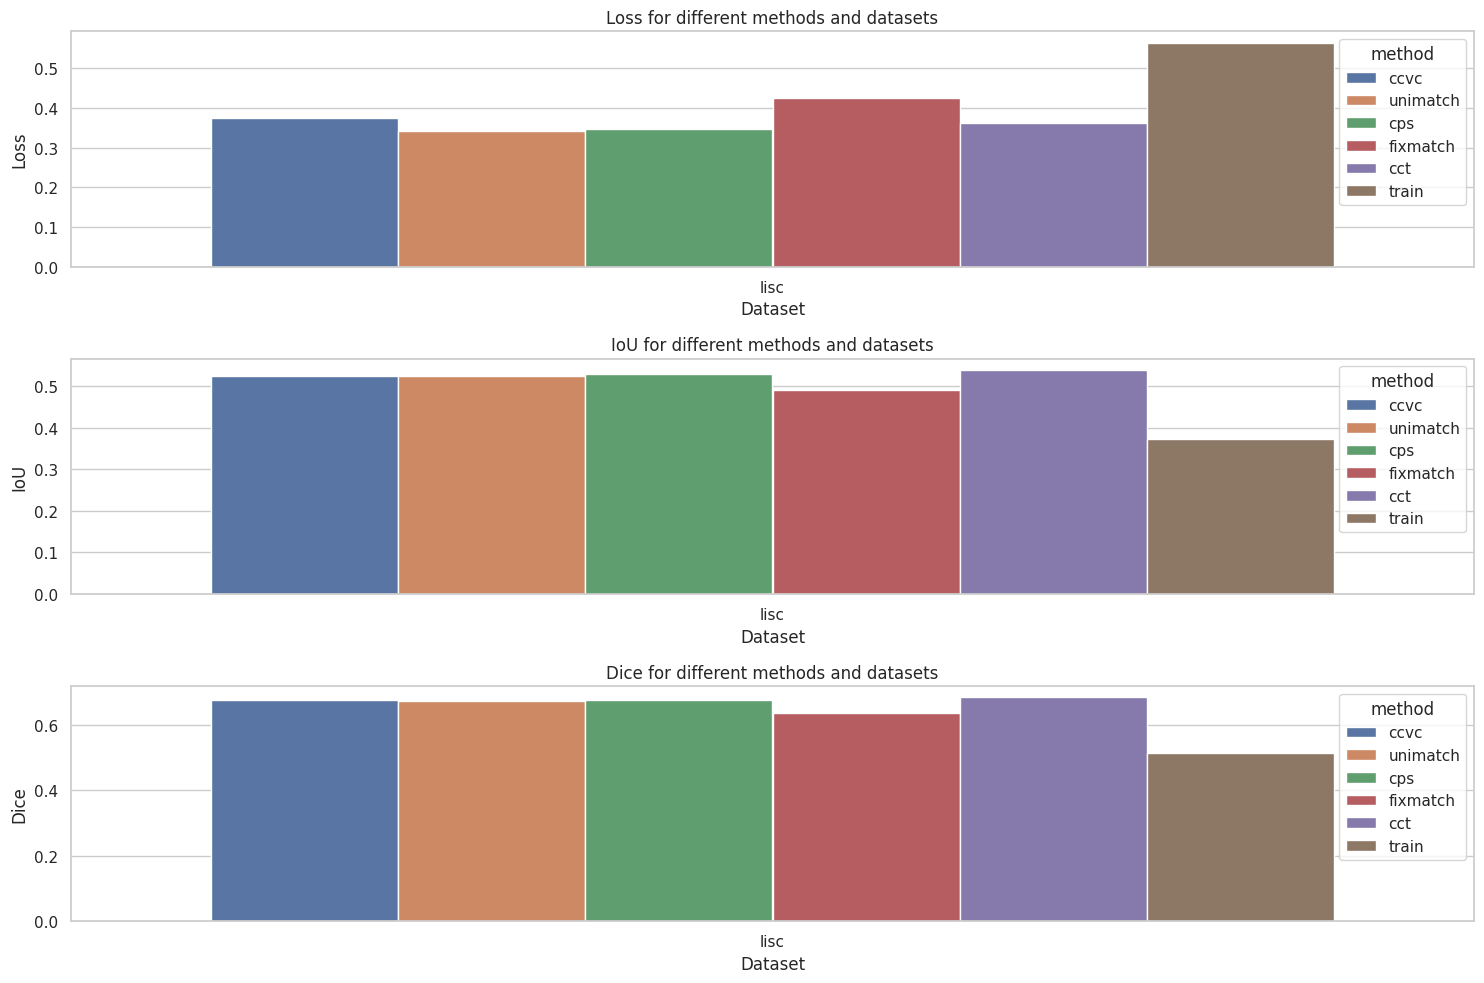

In [6]:
# Plotting settings
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Create plots for each metric
metrics = ["Loss", "IoU", "Dice"]
for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i + 1)
    sns.barplot(x="dataset", y=metric, hue="method", data=results_df)
    plt.title(f"{metric} for different methods and datasets")
    plt.xlabel("Dataset")
    plt.ylabel(metric)

plt.tight_layout()
plt.show()